Your goal in this notebook would be predict formation energy of organic molecules from the [QM9 dataset](http://quantum-machine.org/datasets/). We begin with a simple GCNN and gradually build more complex models.

The notebook uses the [pytorch documnetation](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) the [pytorch-geometric example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/qm9_nn_conv.py).

The notebook runs reasonably fast both on CPU and GPU. You will want GPU for the bonus task.

In [ ]:
# Install the required packages
# A failure here probably means that Colab environment has changed
# You can grab the latest config from one of the Colab notebooks here:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-co

In [ ]:
import pathlib

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
import networkx as nx

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set, GCNConv
from torch_geometric.utils import remove_self_loops, to_networkx

import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm.auto import trange

In [ ]:
# The column in y contains the formation energy. Other columns are described here:
# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html
TARGET_Y = 7

class SelectTarget(object):
    def __init__(self, target_column: int):
        self.target_column = target_column

    def __call__(self, data: torch.Tensor) -> torch.Tensor:
        data.y = data.y[:, self.target_column]
        return data

In [ ]:
def draw_graph(graph: torch_geometric.data.data.Data) -> Image:
    """
    Plots a molecule from QM9 dataset. Node labels are atomic numbers.
    Edge lengths and node positions are arbitrary.
    """
    graph_nx = to_networkx(graph,
                           to_undirected=True)
    graph_graphviz = nx.nx_agraph.to_agraph(graph_nx)
    for node, type_ in zip(graph_graphviz.iternodes(), graph.z.detach().numpy()):
        node.attr['label'] = str(type_)
    return Image(graph_graphviz.draw(format='png', prog="neato"))

Load the QM9 dataset

In [ ]:
dataset_path = pathlib.Path('data', 'QM9')
# We use "raw" prefix as we'll later reload the dataset
# with the preprocessing steps included
raw_dataset = QM9(dataset_path)

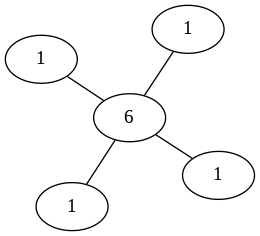

In [ ]:
draw_graph(raw_dataset[0])

Data Handling of Graphs
-----------------------

A graph is used to model pairwise relations (edges) between objects (nodes).
A single graph in PyG is described by an instance of `torch_geometric.data.Data`, which holds the following attributes by default:

- `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`
- `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`
- `data.y`: Target to train against (may have arbitrary shape), *e.g.*, node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`
- `data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

None of these attributes are required.
In fact, the `~torch_geometric.data.Data` object is not even restricted to these attributes.
We can, *e.g.*, extend it by `data.face` to save the connectivity of triangles from a 3D mesh in a tensor with shape `[3, num_faces]` and type `torch.long`.

Note:
    PyTorch and `torchvision` define an example as a tuple of an image and a target.
    We omit this notation in PyG to allow for various data structures in a clean and understandable way.

Let's see the first molecule we have loaded:

In [ ]:
raw_dataset[0].x

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In QM9 the `x` attribute contains the atom features from the [Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212) paper. `[0:7]`  contain one-hot encoded atom types, `7` is the atomic number, `8` is boolean indicator whether the atom is [aromatic](https://rdkit.readthedocs.io/en/latest/RDKit_Book.html), `[9:12]` conain one-hot encoded [hybridization type](https://www.rdkit.org/docs/Cookbook.html#hybridization-type-and-count).

In [ ]:
raw_dataset[0].edge_index

tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])

Node 0 is connected to each other node with a bi-directional edge

In [ ]:
raw_dataset[0].edge_attr

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

Edge attributes contain one-hot-encoded [bond types](https://www.rdkit.org/docs/cppapi/classRDKit_1_1Bond.html#a2c93af0aeb3297ee77b6afdc27b68d6f).

In [ ]:
raw_dataset[0].y

tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])

`y` contains [molecular properties](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html). We are intereseted in No. `7` -- the formation energy.

In [ ]:
raw_dataset[0].pos

tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])

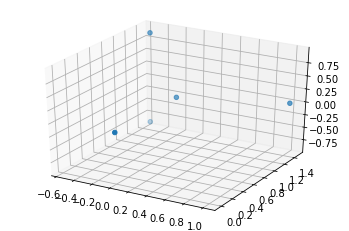

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*raw_dataset[0].pos.T);

`pos` contains the spatial coordinates of the atoms.

In [ ]:
raw_dataset[0].z

tensor([6, 1, 1, 1, 1])

`z` is not mentioned in the general graph format descrition, it is an extra attribute of this particular dataset. It contains the atomic numbers. So our molecule is $\text{CH}_4$.

# Training a GCNN
Define a transformation of the input data. `SelectTarget` selects the target column and `torch_geometric.transforms.Distance` appends Euclidean distance between `pos` vectors to the edge attributes.

In [ ]:
transform = T.Compose([SelectTarget(TARGET_Y), T.Distance(norm=False)])
torch.manual_seed(42)
dataset = QM9(dataset_path, transform=transform).shuffle()

# Normalize targets to mean = 0 and std = 1.
mean = dataset.data.y.mean(dim=0, keepdim=True)
std = dataset.data.y.std(dim=0, keepdim=True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, TARGET_Y].item(), std[:, TARGET_Y].item()

# Split datasets.
test_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
train_dataset = dataset[20000:40000]

# Create pytorch objects for handling the data
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
class SlimeNet(torch.nn.Module):
    """
    A base bones graph convolutional neural network for molecules.
    If consists of a linear transofrmation of the nodes' features
    followed by a single graph convolution operation, a set2set transformation,
    a hidden layer, and an output layer.
    """

    def __init__(self, hidden_dim: int):
        """
        Args:
            hidden_dim: the number of units used in the hidden layers
        """
        super().__init__()
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)
        self.conv = GCNConv(hidden_dim, hidden_dim)
        self.set2set = Set2Set(hidden_dim, processing_steps=1)
        self.lin1 = torch.nn.Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data: torch_geometric.data.Data) -> torch_geometric.data.Data:
        # Nothing special, just a sequece of transformations
        # But pay attention to the API signatures of the graph layers
        # Apply a linear layer+ReLu to the featues of each node independenly
        out = F.relu(self.lin0(data.x))
        # Apply a graph convolution
        out = F.relu(self.conv(out, data.edge_index))
        # Apply a Set2Set pooling operation from
        # "Order Matters: Sequence to sequence for sets"
        # https://arxiv.org/abs/1511.06391 paper
        out = self.set2set(out, data.batch)
        # And a classic fully-connected head
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

Now is the time for training our network. In the interest of speed we take only a smal part of the training data and small NN. It should finish in <100 seconds both on CPU and GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def evaluate_model(model: torch.nn.Module,
                   epochs: int = 15):
    """
    A counvinience routine for evaluating predictive models for our subset of QM9
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.7, patience=5,
                                                           min_lr=0.00001)

    def train(epoch):
        model.train()
        loss_all = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            loss = F.mse_loss(model(data), data.y)
            loss.backward()
            loss_all += loss.item() * data.num_graphs
            optimizer.step()
        return loss_all / len(train_loader.dataset)


    def test(loader):
        model.eval()
        error = 0

        for data in loader:
            data = data.to(device)
            error += (model(data) * std - data.y * std).abs().sum().item()  # MAE
        return error / len(loader.dataset)


    best_val_error = None
    for epoch in trange(epochs):
        lr = scheduler.optimizer.param_groups[0]['lr']
        loss = train(epoch)
        val_error = test(val_loader)
        scheduler.step(val_error)

        if best_val_error is None or val_error <= best_val_error:
            test_error = test(test_loader)
            best_val_error = val_error

        print(f'Epoch: {epoch:03d}, LR: {lr:7f}, Loss: {loss:.7f}, '
              f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

Let's evaluate our simple NN with hidden dimensionalit 16 and 32. We don't train to saturation to save your time, but the wider network shoud sltill slightly outperform the narrower one.

In [ ]:
evaluate_model(SlimeNet(16))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.9360331, Val MAE: 682.2458071, Test MAE: 692.3671910
Epoch: 001, LR: 0.001000, Loss: 0.5933711, Val MAE: 532.5896621, Test MAE: 543.4872605
Epoch: 002, LR: 0.001000, Loss: 0.4681427, Val MAE: 453.7991786, Test MAE: 463.2675619
Epoch: 003, LR: 0.001000, Loss: 0.4253800, Val MAE: 456.0827299, Test MAE: 463.2675619
Epoch: 004, LR: 0.001000, Loss: 0.4050135, Val MAE: 389.3669334, Test MAE: 399.0253523
Epoch: 005, LR: 0.001000, Loss: 0.3909459, Val MAE: 427.9928668, Test MAE: 399.0253523
Epoch: 006, LR: 0.001000, Loss: 0.3846821, Val MAE: 444.2028874, Test MAE: 399.0253523
Epoch: 007, LR: 0.001000, Loss: 0.3812430, Val MAE: 475.1592473, Test MAE: 399.0253523
Epoch: 008, LR: 0.001000, Loss: 0.3811800, Val MAE: 458.9294548, Test MAE: 399.0253523
Epoch: 009, LR: 0.001000, Loss: 0.3779068, Val MAE: 434.4781626, Test MAE: 399.0253523
Epoch: 010, LR: 0.001000, Loss: 0.3769869, Val MAE: 508.2431073, Test MAE: 399.0253523
Epoch: 011, LR: 0.000700, Loss: 0.3742532, 

In [ ]:
evaluate_model(SlimeNet(32))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.8836413, Val MAE: 668.9182644, Test MAE: 677.8357342
Epoch: 001, LR: 0.001000, Loss: 0.5293412, Val MAE: 475.3916950, Test MAE: 486.8954077
Epoch: 002, LR: 0.001000, Loss: 0.4269350, Val MAE: 456.2628456, Test MAE: 467.2441163
Epoch: 003, LR: 0.001000, Loss: 0.3951944, Val MAE: 385.7909851, Test MAE: 397.3177473
Epoch: 004, LR: 0.001000, Loss: 0.3840355, Val MAE: 394.2677631, Test MAE: 397.3177473
Epoch: 005, LR: 0.001000, Loss: 0.3777852, Val MAE: 419.7537223, Test MAE: 397.3177473
Epoch: 006, LR: 0.001000, Loss: 0.3743338, Val MAE: 514.4352704, Test MAE: 397.3177473
Epoch: 007, LR: 0.001000, Loss: 0.3774441, Val MAE: 357.2263874, Test MAE: 368.7577220
Epoch: 008, LR: 0.001000, Loss: 0.3740300, Val MAE: 407.0170035, Test MAE: 368.7577220
Epoch: 009, LR: 0.001000, Loss: 0.3700502, Val MAE: 494.9057321, Test MAE: 368.7577220
Epoch: 010, LR: 0.001000, Loss: 0.3727412, Val MAE: 358.4330218, Test MAE: 368.7577220
Epoch: 011, LR: 0.001000, Loss: 0.3694545, 

**Task 1.** Now is the time for upgrading the model! Build and test a network like `SlimeNet`, but with 2 and 3 applications of the *same* convolutional layer. [1 point]

In [ ]:
class ConvNetSame(torch.nn.Module):
    def __init__(self, hidden_dim: int, n_convs: int):
        """
        Args:
            hidden_dim: the number of units used in the hidden layers
            n_convs: the number of applications of the GCNN layer
        """
        super().__init__()
        self.n_convs = n_convs
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)
        self.conv = GCNConv(hidden_dim, hidden_dim)
        self.set2set = Set2Set(hidden_dim, processing_steps=1)
        self.lin1 = torch.nn.Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data: torch_geometric.data.Data) -> torch_geometric.data.Data:
        out = F.relu(self.lin0(data.x))

        # Remember, you need to pass the graph through the same
        # layer n_convs times, like in a recurrent network
        # Use ReLu activation
        ### YOUR CODE HERE

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

Evaluate your model. It's [likely](https://pytorch.org/docs/stable/notes/randomness.html) that you should ovserve a slight improvement in quality.

In [ ]:
evaluate_model(ConvNetSame(hidden_dim=16, n_convs=2))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.8940414, Val MAE: 647.8607646, Test MAE: 658.8819614
Epoch: 001, LR: 0.001000, Loss: 0.5541800, Val MAE: 516.7101799, Test MAE: 527.0412789
Epoch: 002, LR: 0.001000, Loss: 0.4375853, Val MAE: 439.9686924, Test MAE: 449.8641040
Epoch: 003, LR: 0.001000, Loss: 0.4019175, Val MAE: 389.9388845, Test MAE: 399.5719382
Epoch: 004, LR: 0.001000, Loss: 0.3853585, Val MAE: 444.8763237, Test MAE: 399.5719382
Epoch: 005, LR: 0.001000, Loss: 0.3754831, Val MAE: 489.8162701, Test MAE: 399.5719382
Epoch: 006, LR: 0.001000, Loss: 0.3732530, Val MAE: 405.4942276, Test MAE: 399.5719382
Epoch: 007, LR: 0.001000, Loss: 0.3701028, Val MAE: 417.5050028, Test MAE: 399.5719382
Epoch: 008, LR: 0.001000, Loss: 0.3690686, Val MAE: 477.0847288, Test MAE: 399.5719382
Epoch: 009, LR: 0.001000, Loss: 0.3710458, Val MAE: 424.6791402, Test MAE: 399.5719382
Epoch: 010, LR: 0.000700, Loss: 0.3672235, Val MAE: 460.8074208, Test MAE: 399.5719382
Epoch: 011, LR: 0.000700, Loss: 0.3677407, 

In [ ]:
evaluate_model(ConvNetSame(hidden_dim=16, n_convs=3))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.9215444, Val MAE: 623.8724602, Test MAE: 634.2953511
Epoch: 001, LR: 0.001000, Loss: 0.5305246, Val MAE: 488.7781970, Test MAE: 498.5095070
Epoch: 002, LR: 0.001000, Loss: 0.4249897, Val MAE: 464.9446894, Test MAE: 473.8717029
Epoch: 003, LR: 0.001000, Loss: 0.3971307, Val MAE: 404.2336904, Test MAE: 413.5291329
Epoch: 004, LR: 0.001000, Loss: 0.3905885, Val MAE: 410.5102604, Test MAE: 413.5291329
Epoch: 005, LR: 0.001000, Loss: 0.3836010, Val MAE: 408.6550069, Test MAE: 413.5291329
Epoch: 006, LR: 0.001000, Loss: 0.3798775, Val MAE: 461.8685885, Test MAE: 413.5291329
Epoch: 007, LR: 0.001000, Loss: 0.3783717, Val MAE: 361.7762312, Test MAE: 372.9052937
Epoch: 008, LR: 0.001000, Loss: 0.3797040, Val MAE: 469.4087066, Test MAE: 372.9052937
Epoch: 009, LR: 0.001000, Loss: 0.3753314, Val MAE: 455.5356615, Test MAE: 372.9052937
Epoch: 010, LR: 0.001000, Loss: 0.3771466, Val MAE: 351.7962670, Test MAE: 363.5930024
Epoch: 011, LR: 0.001000, Loss: 0.3758376, 

**Task 2.** Build and test a network like `SlimeNet`, but with 2 separate convolutional layers. [1 point]

In [ ]:
class Conv2Net(torch.nn.Module):
    def __init__(self, hidden_dim: int):
        """
        Args:
            hidden_dim: the number of units used in the hidden layers
        """
        super().__init__()
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)

        # Define two layers. Remember, to have two layers with
        # different 
        ### YOUR CODE HERE

        self.set2set = Set2Set(hidden_dim, processing_steps=1)
        self.lin1 = torch.nn.Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data: torch_geometric.data.Data) -> torch_geometric.data.Data:
        out = F.relu(self.lin0(data.x))

        # Apply the GCNN layers. Don't forget ReLu
        ### YOUR CODE HERE

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

In [ ]:
evaluate_model(Conv2Net(hidden_dim=16))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.9164342, Val MAE: 648.8570692, Test MAE: 659.3904365
Epoch: 001, LR: 0.001000, Loss: 0.5555551, Val MAE: 480.6351492, Test MAE: 489.5100495
Epoch: 002, LR: 0.001000, Loss: 0.4374248, Val MAE: 468.9225433, Test MAE: 478.5932634
Epoch: 003, LR: 0.001000, Loss: 0.4111953, Val MAE: 468.2647042, Test MAE: 477.8223878
Epoch: 004, LR: 0.001000, Loss: 0.3964312, Val MAE: 400.6364951, Test MAE: 410.4641059
Epoch: 005, LR: 0.001000, Loss: 0.3896268, Val MAE: 429.9115584, Test MAE: 410.4641059
Epoch: 006, LR: 0.001000, Loss: 0.3858446, Val MAE: 411.6774718, Test MAE: 410.4641059
Epoch: 007, LR: 0.001000, Loss: 0.3816277, Val MAE: 455.4806769, Test MAE: 410.4641059
Epoch: 008, LR: 0.001000, Loss: 0.3782912, Val MAE: 441.4584630, Test MAE: 410.4641059
Epoch: 009, LR: 0.001000, Loss: 0.3770020, Val MAE: 356.9592451, Test MAE: 368.0410718
Epoch: 010, LR: 0.001000, Loss: 0.3790789, Val MAE: 449.2885434, Test MAE: 368.0410718
Epoch: 011, LR: 0.001000, Loss: 0.3740066, 

The final and most diffucult task is to create a model that would use the continuous kernel-based convolutional operator from the "[Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212)" paper. It's implemented in pytorch-geometric as `NNConv` and the documentation is available [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.NNConv), [2 points].

In [ ]:
class PaperNet(torch.nn.Module):
    def __init__(self, hidden_dim: int, n_convs: int):
        """
        Args:
            hidden_dim: the number of units used in the hidden layers
            n_convs: the number of applications of the GCNN layer
        """
        super().__init__()
        self.n_convs = n_convs
        self.lin0 = torch.nn.Linear(dataset.num_features, hidden_dim)

        # Define the NNConv layer and the fully-connected nerual network
        # inside it. The suggested structure for the FCN is
        # Linear(5, hidden_dim*2)
        # ReLu activation
        # Linear(hidden_dim*2, hidden_dim * hidden_dim)
        ### YOUR CODE HERE

        self.set2set = Set2Set(hidden_dim, processing_steps=1)
        self.lin1 = torch.nn.Linear(2 * hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data: torch_geometric.data.Data) -> torch_geometric.data.Data:
        out = F.relu(self.lin0(data.x))
        # Pass the graph through the same NNConv
        # layer n_convs times, like in a recurrent network
        # Use ReLu activation
        ### YOUR CODE HERE
        
        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        return out.view(-1)

Note that we use a very simplified configuration for evaluation in order to make it quick, so it's not guranteed that our more complex model would have better performance.

In [ ]:
evaluate_model(PaperNet(hidden_dim=16, n_convs=2))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 000, LR: 0.001000, Loss: 0.7273769, Val MAE: 526.2695274, Test MAE: 538.8549044
Epoch: 001, LR: 0.001000, Loss: 0.4621707, Val MAE: 463.6644756, Test MAE: 477.6979842
Epoch: 002, LR: 0.001000, Loss: 0.4256778, Val MAE: 469.8777911, Test MAE: 477.6979842
Epoch: 003, LR: 0.001000, Loss: 0.4072667, Val MAE: 410.0160400, Test MAE: 418.6074025
Epoch: 004, LR: 0.001000, Loss: 0.4109407, Val MAE: 412.5140201, Test MAE: 418.6074025
Epoch: 005, LR: 0.001000, Loss: 0.3860084, Val MAE: 472.1242727, Test MAE: 418.6074025
Epoch: 006, LR: 0.001000, Loss: 0.3863121, Val MAE: 464.3499615, Test MAE: 418.6074025
Epoch: 007, LR: 0.001000, Loss: 0.3887906, Val MAE: 391.2905398, Test MAE: 401.2649263
Epoch: 008, LR: 0.001000, Loss: 0.3812361, Val MAE: 387.6284450, Test MAE: 396.5937043
Epoch: 009, LR: 0.001000, Loss: 0.3730279, Val MAE: 418.3739087, Test MAE: 396.5937043
Epoch: 010, LR: 0.001000, Loss: 0.3728482, Val MAE: 439.6219126, Test MAE: 396.5937043
Epoch: 011, LR: 0.001000, Loss: 0.3723975, 

**Bonus part**. Achieve test MAE score of 80. We don't gurantee it's possible in the timeframe allocated to the task, so brace yourself for a "long" 2-hour training. Feel free to use the whole dataset and more iterations for training. You might even want to use the complete graphs, where all atoms are connected to each other, not only the ones where there is a covalent bond. [3 points, not included in the total, but can substitute for ordinary tasks in achieveing the full total grade. 3 points for MAE <= 80, 2 points for MAE <= 120, 1 point for MAE <= 150]